In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


base_path = '../data/f1Data/'

drivers = pd.read_csv(base_path + 'drivers.csv')
results = pd.read_csv(base_path + 'results.csv')
races = pd.read_csv(base_path + 'races.csv')
constructors = pd.read_csv(base_path + 'constructors.csv')
lap_times = pd.read_csv(base_path + 'lap_times.csv')
pit_stops = pd.read_csv(base_path + 'pit_stops.csv')


drivers.head()


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [2]:
drivers.isnull().sum()

driverId       0
driverRef      0
number         0
code           0
forename       0
surname        0
dob            0
nationality    0
url            0
dtype: int64

In [3]:
results.head() 

results.isnull().sum()


resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder      0
points             0
laps               0
time               0
milliseconds       0
fastestLap         0
rank               0
fastestLapTime     0
fastestLapSpeed    0
statusId           0
dtype: int64

In [4]:
merged = results.merge(races, on='raceId', suffixes=('', '_race'))

merged = merged.merge(drivers, on='driverId', suffixes=('', '_driver'))

merged = merged.merge(constructors, on='constructorId', suffixes=('', '_team'))

merged[['raceId', 'year', 'name', 'surname', 'grid', 'positionOrder', 'constructorRef']].head()


,raceId,year,name,surname,grid,positionOrder,constructorRef
0,18,2008,Australian Grand Prix,Hamilton,1,1,mclaren
1,19,2008,Malaysian Grand Prix,Hamilton,9,5,mclaren
2,20,2008,Bahrain Grand Prix,Hamilton,3,13,mclaren
3,21,2008,Spanish Grand Prix,Hamilton,5,3,mclaren
4,22,2008,Turkish Grand Prix,Hamilton,3,2,mclaren


In [5]:
merged['podium_finish'] = merged['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

merged['podium_finish'].value_counts()


podium_finish
0    23362
1     3397
Name: count, dtype: int64

In [6]:
ml_data = merged[['grid', 'positionOrder', 'podium_finish']].copy()

ml_data = ml_data.dropna()

X = ml_data[['grid']]
y = ml_data['podium_finish']

X.head(), y.head()


(   grid
 0     1
 1     9
 2     3
 3     5
 4     3,
 0    1
 1    0
 2    0
 3    1
 4    1
 Name: podium_finish, dtype: int64)

In [7]:
# I selected these features because they are likely to influence race outcomes:
# grid: starting position is known to affect race results
# driverId: accounts for the skill/experience of the driver
# constructorId: reflects the team's overall performance and resources
# year and round: shows historical trends and seasonal changes (like new regulations, team upgrades)
features = merged[['grid', 'driverId', 'constructorId', 'year', 'round']]

# Dropping missing values to ensure that the dataset is clean before training the model.
# I matched the target index with features to keep alignment.
features = features.dropna()
target = merged['podium_finish'].loc[features.index]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8804185351270553

Confusion Matrix:
 [[4417  231]
 [ 409  295]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      4648
           1       0.56      0.42      0.48       704

    accuracy                           0.88      5352
   macro avg       0.74      0.68      0.71      5352
weighted avg       0.87      0.88      0.87      5352



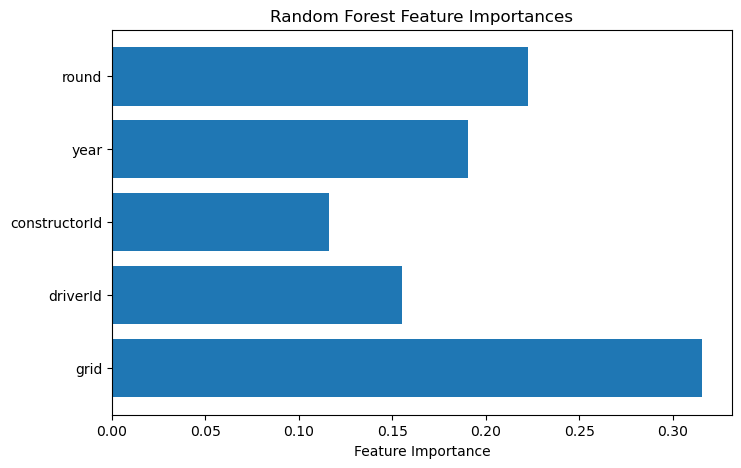

In [11]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = features.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()


In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8804185351270553

Confusion Matrix:
 [[4417  231]
 [ 409  295]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      4648
           1       0.56      0.42      0.48       704

    accuracy                           0.88      5352
   macro avg       0.74      0.68      0.71      5352
weighted avg       0.87      0.88      0.87      5352



In [13]:
# Unsupervised Learning clustering of drivers based on performance

In [14]:
# i already jhave the merged dataset so i will re-use. 
driver_stats = merged.copy()

# Calculating positions gained
driver_stats['positions_gained'] = driver_stats['grid'] - driver_stats['positionOrder']

# Group by driver and calculate averages
driver_perf = driver_stats.groupby('driverId').agg({
    'grid': 'mean',
    'positionOrder': 'mean',
    'positions_gained': 'mean',
    'raceId': 'count'  # number of races
}).rename(columns={'grid': 'avg_grid', 'positionOrder': 'avg_finish', 'positions_gained': 'avg_gain', 'raceId': 'num_races'})

# Drop any drivers with very few races (less reliable)
driver_perf = driver_perf[driver_perf['num_races'] >= 10]

driver_perf.head()


,avg_grid,avg_finish,avg_gain,num_races
driverId,,,,
1,4.300562,5.019663,-0.719101,356
2,11.336957,10.722826,0.614130,184
3,6.902913,8.252427,-1.349515,206
4,8.579208,8.492574,0.086634,404
5,13.741071,13.285714,0.455357,112


In [15]:
# adding drivername for better overview

In [16]:
# Select only the relevant columns from the drivers dataframe
driver_names = drivers[['driverId', 'forename', 'surname']]

# Merge into the driver_perf dataframe
driver_perf = driver_perf.merge(driver_names, on='driverId')

# Optional: create a full name column for easier readability
driver_perf['driver_name'] = driver_perf['forename'] + ' ' + driver_perf['surname']

# Reorder columns so names come first
cols = ['driverId', 'driver_name', 'avg_grid', 'avg_finish', 'avg_gain', 'num_races']
if 'cluster' in driver_perf.columns:
    cols.append('cluster')
if 'pca1' in driver_perf.columns and 'pca2' in driver_perf.columns:
    cols.extend(['pca1', 'pca2'])

driver_perf = driver_perf[cols]

# View result
driver_perf.head()


,driverId,driver_name,avg_grid,avg_finish,avg_gain,num_races
0,1,Lewis Hamilton,4.300562,5.019663,-0.719101,356
1,2,Nick Heidfeld,11.336957,10.722826,0.614130,184
2,3,Nico Rosberg,6.902913,8.252427,-1.349515,206
3,4,Fernando Alonso,8.579208,8.492574,0.086634,404
4,5,Heikki Kovalainen,13.741071,13.285714,0.455357,112


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(driver_perf[['avg_grid', 'avg_finish', 'avg_gain']])


In [18]:
from sklearn.cluster import KMeans

# Let's try 3 clusters to start with
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels back to dataframe
driver_perf['cluster'] = clusters

# Check distribution
driver_perf['cluster'].value_counts()


/Users/vivek/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster
2    208
0    149
1     20
Name: count, dtype: int64

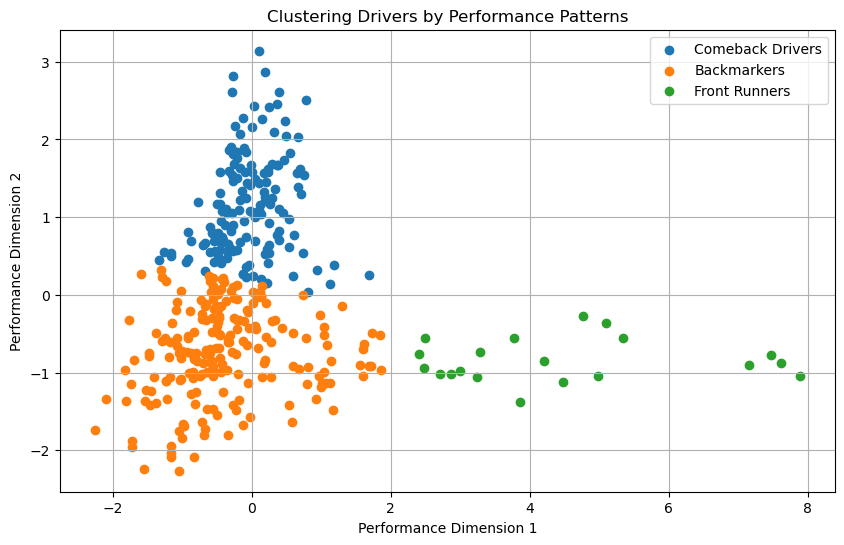

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA to reduce dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Add PCA results to the dataframe with more descriptive names
driver_perf['Performance Dimension 1'] = pca_result[:, 0]
driver_perf['Performance Dimension 2'] = pca_result[:, 1]

# Map cluster numbers to meaningful labels
cluster_labels = {
    0: 'Comeback Drivers',
    1: 'Front Runners',
    2: 'Backmarkers'
}
driver_perf['driver_type'] = driver_perf['cluster'].map(cluster_labels)
# Cluster meanings:
# 0 → Comeback Drivers: strong gainers
# 1 → Front Runners: top performers
# 2 → Backmarkers: lower grid and finish

# Plot the clusters with clearer labels
plt.figure(figsize=(10, 6))

for label in driver_perf['driver_type'].unique():
    subset = driver_perf[driver_perf['driver_type'] == label]
    plt.scatter(
        subset['Performance Dimension 1'],
        subset['Performance Dimension 2'],
        label=label
    )

plt.title('Clustering Drivers by Performance Patterns')
plt.xlabel('Performance Dimension 1')
plt.ylabel('Performance Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import joblib

# Save model for Part 1 (Streamlit UI)
joblib.dump(rf, '../part1_presentation/model.pkl')


['../part1_presentation/model.pkl']

In [21]:
import joblib

# Save model for Part 2
joblib.dump(rf, '../part2_rag_llama/model.pkl')


['../part2_rag_llama/model.pkl']

In [22]:
##  Reflection

# Working on this project helped me better understand how supervised and unsupervised machine learning can be applied to real-world data. Even though the goal was to predict whether a driver would finish on the podium — and the actual outcomes were already known — it was still valuable to simulate predictions and see how the model performed.

# Through data cleaning and feature selection, I saw how much impact the input data has on results. For example, `grid position` turned out to be one of the most important predictors, which makes sense intuitively.

# For the supervised model, I used Random Forest because it performed well with minimal tuning. I also used KMeans and PCA to cluster drivers and explore performance patterns without labels, which helped identify types of drivers like “Comeback Drivers”.

# One challenge was handling many IDs (drivers, teams, races) and turning them into meaningful features, which I solved through merging and careful mapping.

# Overall, I gained confidence in training models, cleaning data, and deploying a working prototype — even if it's just for historical simulation. If I had more time, I’d experiment with more features (like weather or lap data), tune hyperparameters more deeply, and try comparing models.

